In [ ]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import matplotlib.lines  as mlines
import sys
import json
import torch


from matplotlib          import rcParams
rcParams.update({'figure.dpi': 200})
mpl.rcParams.update({'font.size': 10})
plt.rcParams['figure.dpi'] = 150

## import own functions
sys.path.insert(1, '/STER/silkem/MACE/src/mace')
import src.mace.autoencoder  as ae
import src.mace.dataset      as ds
import src.mace.train        as tr
from src.mace.neuralODE    import Solver
import src.mace.plotting     as pl


sys.path.append('/STER/silkem/ChemTorch/src')
import rates as rate
## get species
specs, parnt, convs = rate.read_specs_file('C', 16)
specs_dict = dict()
idx_specs  = dict()
for i in range(len(specs)):
    specs_dict[specs[i]] = i
    idx_specs[i] = specs[i]

%load_ext autoreload
%autoreload 2

: 

### Functions

In [68]:
def load_loss(loc, type):
    loss = {'total_loss'       : np.load(loc+type+'/total_loss.npy'),
            'total_mse_loss'   : np.load(loc+type+'/total_mse_loss.npy'),
            'total_rel_loss'   : np.load(loc+type+'/total_rel_loss.npy'),
            'idv_mse_loss'     : np.load(loc+type+'/idv_mse_loss.npy'),
            'idv_rel_loss'     : np.load(loc+type+'/idv_rel_loss.npy')
    }
    return loss

def load_model(loc, meta, epoch, sepr):
    cuda   = False
    DEVICE = torch.device("cuda" if cuda else "cpu")
    model = Solver(p_dim=4,z_dim = meta['z_dim'], n_dim=466, DEVICE = DEVICE)

    if sepr == True:
        file = 'nn/nn_'+str(epoch)+'.0.pt'
    else:
        file = 'nn/nn.pt'

    model.load_state_dict(torch.load(loc+file))

    return model

def load_all(outloc, dirname, sepr = False):
    loc   = outloc+dirname+'/'

    ## loading losses
    trainloss = load_loss(loc,'train')
    testloss  = load_loss(loc,'test')

    status = {'train': np.load(loc+'train/status.npy'),
              'test' : np.load(loc+'test/status.npy')}

    ## loading meta file
    with open(loc+'/meta.json', 'r') as f:
        meta=f.read()
    meta  = json.loads(meta)

    ## loading torch model
    model = load_model(loc,meta, '', sepr)

    return meta, model, trainloss, testloss, status


In [69]:
def plot_loss(train, test, log = True, ylim = True):

    fig = plt.figure(figsize = (10,4))
    ax1 = fig.add_subplot((111))

    lw = 1
    a = 0.8

    ## ------------- TRAINING ------------
    ## total loss
    ax1.plot(train['total_loss'    ], ls = '-', marker = 'None', lw = lw, c='navy')
    ## mse loss
    ax1.plot(train['total_mse_loss'], ls = '-', marker = 'x', lw = lw, c='royalblue', alpha = a)
    ## rel loss
    ax1.plot(train['total_rel_loss'], ls = '--', marker = '.', lw = lw, c='lightsteelblue', alpha = a)

    ## ------------ VALIDATING -----------
    ## total loss
    ax1.plot(test['total_loss'    ], ls = '-', marker = 'None', lw = lw, c='maroon')
    ## mse loss
    ax1.plot(test['total_mse_loss'], ls = '-', marker = 'x', lw = lw, c='firebrick', alpha = a)
    ## rel loss
    ax1.plot(test['total_rel_loss'], ls = '--', marker = '.', lw = lw, c='lightcoral', alpha = a)

    ## ------------ legend ----------------
    lw2 = 4
    l_train = mlines.Line2D([],[], color = 'blue', ls = '-' , label='train',lw = lw, alpha = 1)
    l_test  = mlines.Line2D([],[], color = 'red' , ls = '-' , label='test' ,lw = lw, alpha = 1)
    l_tot   = mlines.Line2D([],[], color = 'k'   , ls = '-' , label='total',lw = lw, alpha = 1)
    l_mse   = mlines.Line2D([],[], color = 'grey'     , ls = '-' , marker = 'x',label='mse',lw = lw, alpha = 1)
    l_rel   = mlines.Line2D([],[], color = 'lightgrey', ls = '--' ,marker = '.', label='rel',lw = lw, alpha = 1)
    handles = [l_train, l_test, l_tot, l_mse, l_rel]

    ## ------------ settings --------------
    if log == True:
        ax1.set_yscale('log') 

    if ylim == True:
        ax1.set_ylim([1e-2,1e0])

    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')

    ax1.grid(True, linestyle = '--', linewidth = 0.2)

    ax1.legend(handles=handles,loc = 'upper right')
    
    plt.tight_layout()

    return fig

def plot_loss_specs(train, specs, log = True, ylim = True):
    colors = mpl.cm.viridis(np.linspace(0, 1, len(specs)))

    fig = plt.figure(figsize = (10,6))
    ax1 = fig.add_subplot((111))

    ax1.set_title(specs)

    lw = 1
    a = 1

    ## ------------- TRAINING ------------
    leg_mse  = mlines.Line2D([],[], color = 'k' , ls = '-' , marker = 'x' , label='mse' ,lw = lw, alpha = 1)
    leg_rel  = mlines.Line2D([],[], color = 'k' , ls = '--', marker = '.' , label='rel' ,lw = lw, alpha = 1)
    handles = [leg_mse, leg_rel]

    for j, spec in enumerate(specs):
        i = specs_dict[spec]
        ## total loss
        ax1.plot(train['idv_mse_loss'][:,i]+train['idv_rel_loss'][:,i], ls = ':', lw = lw, c=colors[j], alpha = 1)
        ## mse loss
        ax1.plot(train['idv_mse_loss'][:,i], ls = '-', marker = 'x', lw = lw, c=colors[j], alpha = a, label = 'mse '+spec)
        ## rel loss
        ax1.plot(train['idv_rel_loss'][:,i], ls = '--', marker = '.', lw = lw, c=colors[j], alpha = a, label = 'rel '+spec)
        ## legend
        leg  = mlines.Line2D([],[], color = colors[j] , ls = '-' , label=spec ,lw = 4, alpha = 1)
        handles.append(leg)


    if log == True:
        ax1.set_yscale('log') 

    if ylim == True:
        ax1.set_ylim([1e-10,1e1])

    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')

    ax1.grid(True, linestyle = '--', linewidth = 0.2)

    ax1.legend(handles= handles, loc = 'lower right')
    
    plt.tight_layout()

    return fig

def unscale(x, min, max):

    unscaled = x*np.abs(max-min)+min

    return unscaled

### Loading the model and data

In [70]:
outloc  = '/STER/silkem/MACE/models/'

# dirname = '2023-11-21 16:57:22.470699'
# dirname = '2023-11-21 16:59:12.640608'
# dirname = '2023-11-21 17:02:18.944748'
# dirname = '2023-11-21 17:06:25.281999'

# dirname = '2023-11-23 17:13:42.583941'
# dirname = '2023-11-24 10:34:03.076636'

## Deze met tanh en juiste status saving
# dirname = '2023-11-28 16:37:39.197861'

## test met Frederik
# dirname = '2023-11-28 15:36:34.704840'

## met juiste tijdschaling
dirname = '2023-11-29 17:52:54.611755'


meta, model, trainloss, testloss, status = load_all(outloc, dirname)
meta

{'traindir': 'easy-mace2',
 'lr': 0.001,
 'epochs': 80,
 'z_dim': 10,
 'dt_fract': 0.2,
 'train_time': 9196.581718206406,
 'overhead': 4.375127553939819,
 'samples': 4638,
 'cutoff_abs': 1e-20,
 'done': 'true',
 'norm_mse': 0.00033119284912084483,
 'norm_rel': 6467764332858829.0}

In [71]:
status['train'].shape

(95,)

### Losses

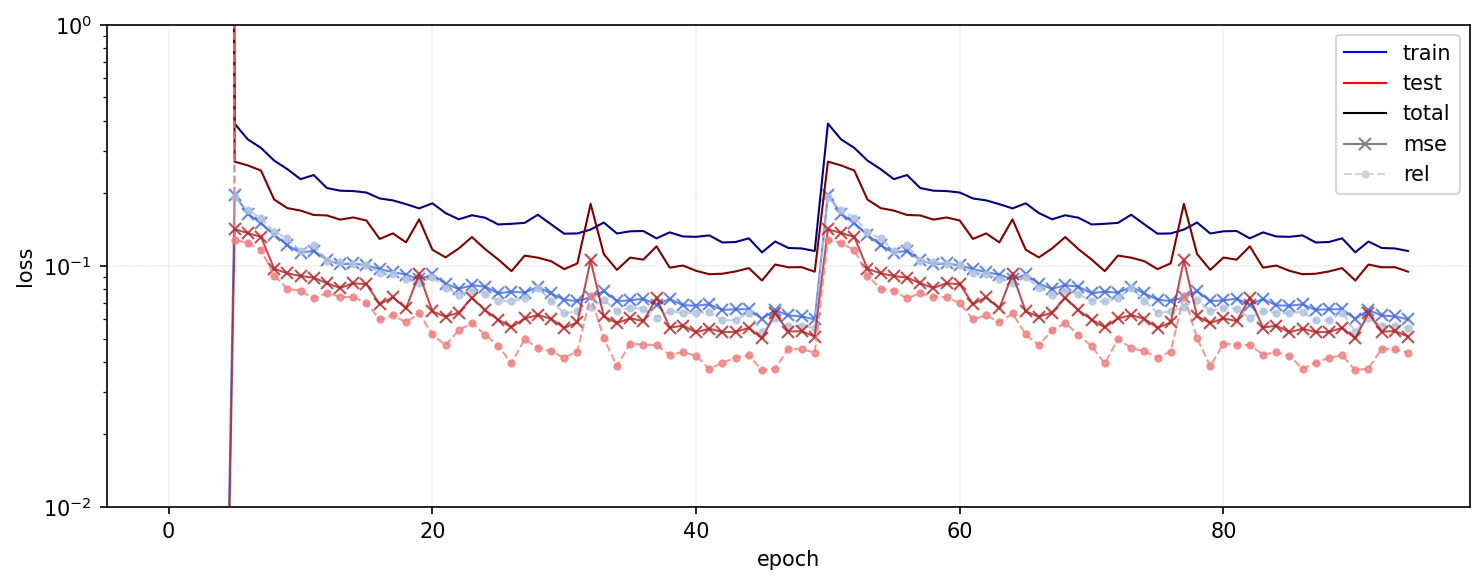

In [72]:
fig = plot_loss(trainloss, testloss, log = True, ylim = True)

plt.show()

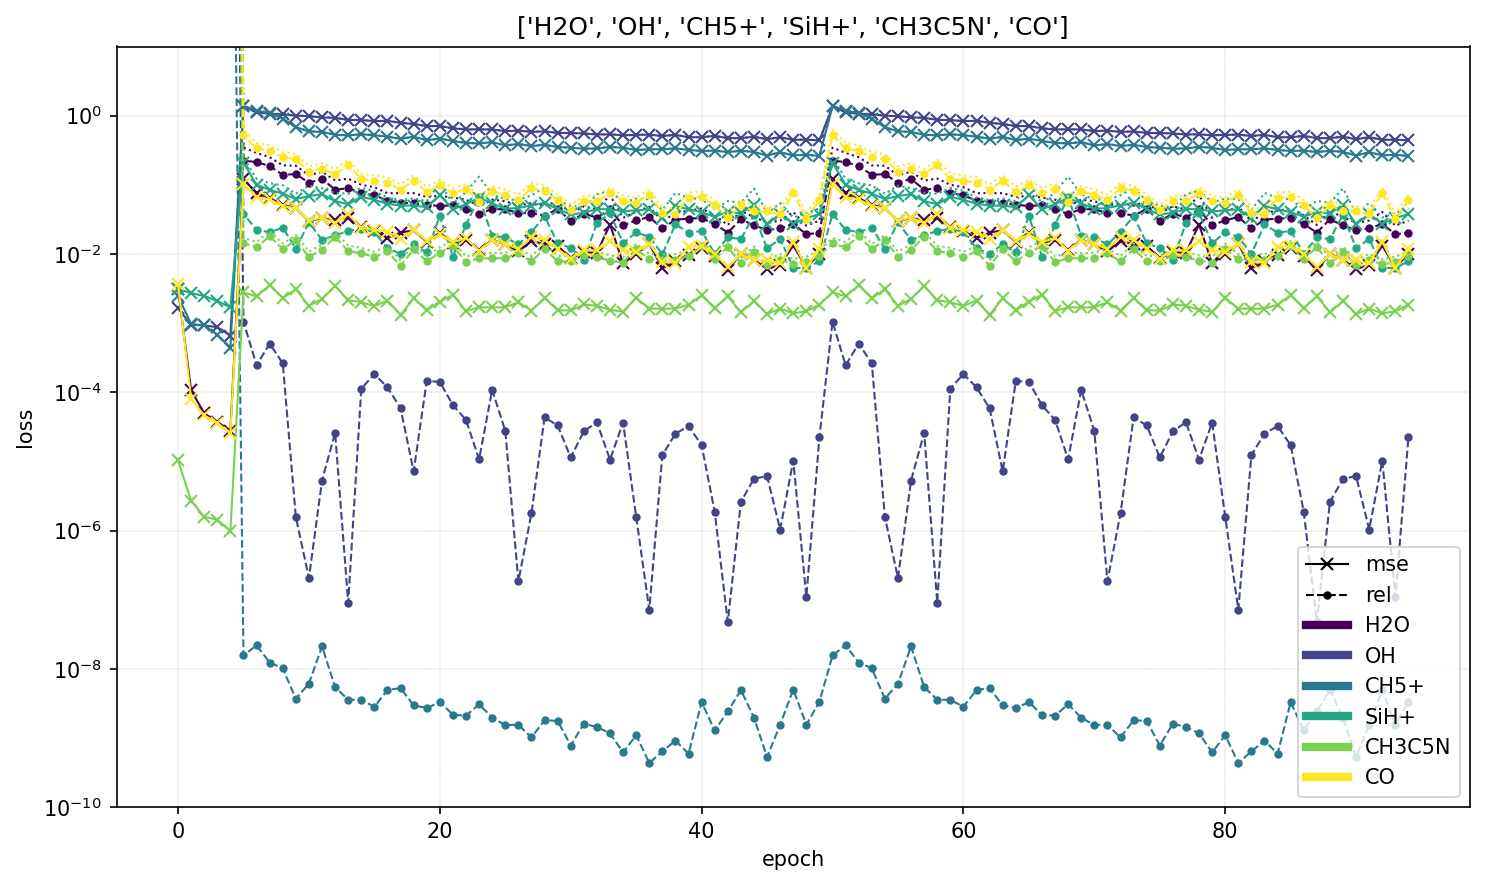

In [73]:
specs = ['H2O', 'OH', 'CH5+', 'SiH+','CH3C5N', 'CO']

fig = plot_loss_specs(trainloss, specs, log = True, ylim = True)
plt.show()

### Test data set

In [39]:
testdir = 'easy-mace2'
# testdir = 'C-short-dtime'

input, dataset, Chempy = ds.get_test_data(testdir, meta['dt_fract'])

print('')
n, n_hat, t, loss, idv_mse, idv_rel, comptime = tr.test(model, input,  f_mse=1, f_rel=1)

376
torch.Size([466, 17]) torch.Size([4]) torch.Size([17])

>>> Testing model...

Test loss       : 2.318719115008672e+18

Solving time [s]: 0.0068700313568115234


In [35]:
t

tensor([[0.0000e+00, 1.2460e-07, 2.4920e-07, 1.4952e-06, 2.7412e-06, 1.5201e-05,
         2.7661e-05, 1.5226e-04, 2.7686e-04, 4.0146e-04, 8.5766e-04, 1.3139e-03,
         1.5314e-03]])

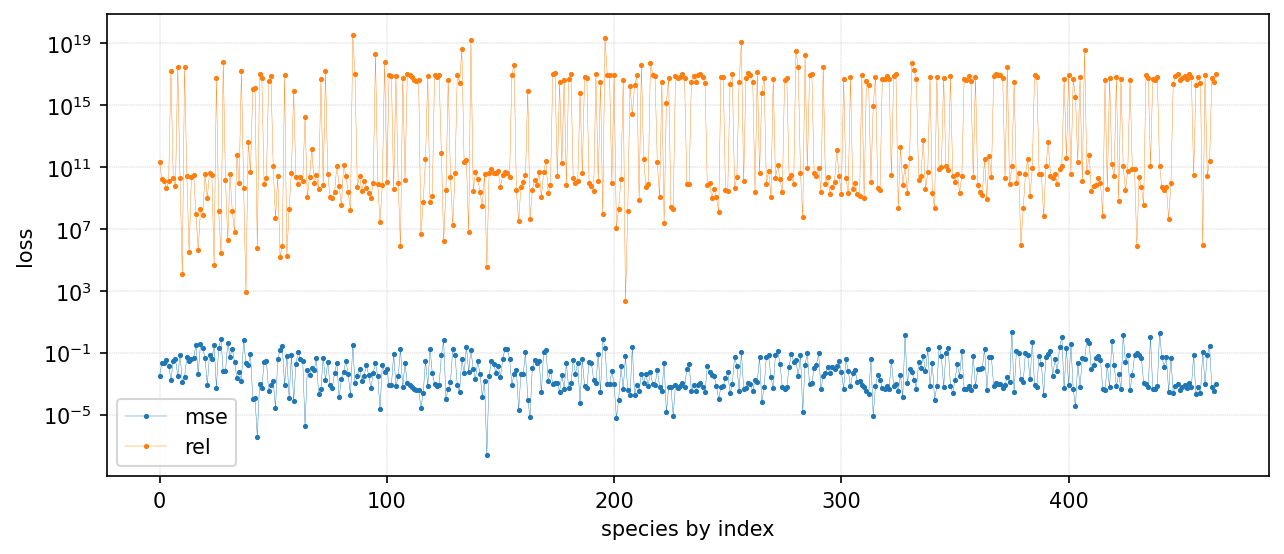

In [36]:
fig = plt.figure(figsize = (10,4))
ax1 = fig.add_subplot((111))

lw = 0.2
ms = 3

ax1.plot(idv_mse[0], ls = '-' , marker = '.' , label='mse' ,lw = lw, alpha = 1, ms = ms)
ax1.plot(idv_rel[0], ls = '-' , marker = '.' , label='rel' ,lw = lw, alpha = 1, ms = ms)

ax1.set_xlabel('species by index')
ax1.set_ylabel('loss')

ax1.set_yscale('log')
ax1.grid(True, linestyle = '--', linewidth = 0.2)


ax1.legend()
plt.show()

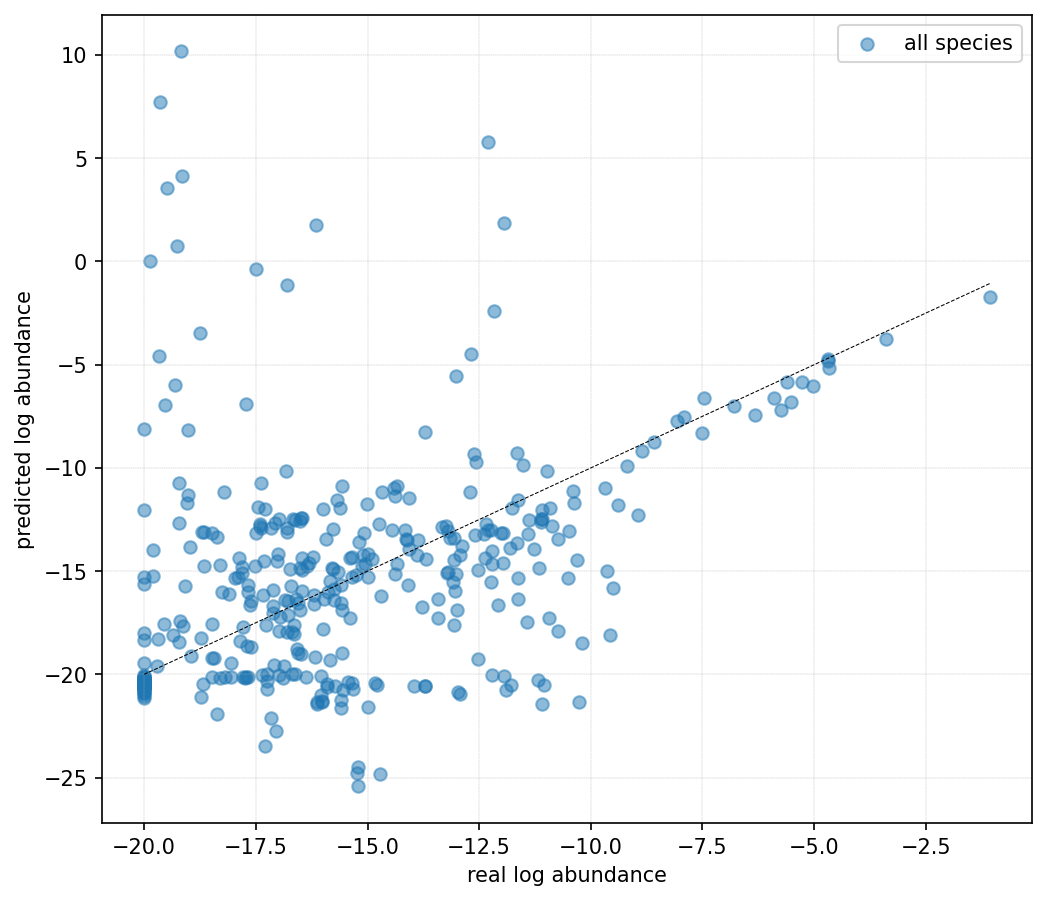

In [42]:
i = 4
cutoff = 1e-20
nmin = np.log10(cutoff)
nmax = np.log10(0.85e-1)

x = unscale(np.linspace(0,1,100), nmin, nmax)

fig = plt.figure(figsize = (8,7))
ax1 = fig.add_subplot((111))

n_un = unscale(n,nmin, nmax)
nhat_un = unscale(n_hat,nmin, nmax).detach().numpy()


alpha = 0.8
ms = 3

i=-1
# specs = ['H2O', 'CO','C2H2', 'C2H', 'HCN', 'CN','OH', 'CH5+', 'SiH+','CH3C5N']
# for spec in specs:
#     idx = specs_dict[spec]
#     ax1.scatter(n_un[0][i][idx],nhat_un[0][i][idx],marker = 'o', alpha = alpha, label = spec) # type: ignore
ax1.scatter(n_un[0][i],nhat_un[0][i],marker = 'o', alpha = 0.5, label = 'all species') # type: ignore

ax1.plot(x,x, '--k', lw = 0.5)

ax1.set_xlabel('real log abundance')
ax1.set_ylabel('predicted log abundance')

ax1.grid(True, linestyle = '--', linewidth = 0.2)

ax1.legend(fontsize = 10)

plt.show()